In [52]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolDescriptors
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns

In [55]:
mtor = pd.read_csv("../../data/chembl_mtor_ic50.csv", delimiter=";")
mtor = mtor[["Molecule ChEMBL ID", "Smiles"]]
mtor["mol"] = mtor.apply(lambda row: Chem.MolFromSmiles(row["Smiles"]), axis=1)
mtor["Source"] = "mtor"
mtor.rename({"Molecule ChEMBL ID":"ID"}, axis=1, inplace=True)

drugbank_mols =  Chem.SDMolSupplier('../../data/drugbank.sdf')
drugbank = [mol for mol in drugbank_mols if mol]
pd_drugbank = pd.DataFrame(drugbank, columns=["mol"])
pd_drugbank["Smiles"] = pd_drugbank.apply(lambda row: Chem.MolToSmiles(row["mol"]), axis=1)
pd_drugbank["Source"] = "drugbank"
pd_drugbank["ID"] = pd_drugbank.apply(lambda row: row["mol"].GetProp("DATABASE_ID"), axis=1)

df = pd.concat([mtor, pd_drugbank]).reset_index(drop=True)
df["c"] = df.apply(lambda row: row["mol"].HasSubstructMatch(Chem.MolFromSmarts("[#6]")), axis=1)
df = df[df["c"]].drop(columns=["c"]).reset_index(drop=True)

[12:58:42] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:58:42] ERROR: Could not sanitize molecule ending on line 20009
[12:58:42] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:58:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:58:42] ERROR: Could not sanitize molecule ending on line 250947
[12:58:42] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:58:42] Explicit valence for atom # 17 O, 3, is greater than permitted
[12:58:42] ERROR: Could not sanitize molecule ending on line 258130
[12:58:42] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[12:58:42] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:58:42] ERROR: Could not sanitize molecule ending on line 261581
[12:58:42] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:58:42] Explicit valence for atom # 47 Mg, 4, is greater than permitted
[12:58:42] ERROR: Could not sanitize

In [77]:
data_vect = df.join(
    pd.DataFrame(
        (Chem.GetMorganFingerprintAsBitVect(mol, 3, 1024).ToList() for mol in df["mol"]), 
        columns=[f"{i}" for i in range(0,1024)]))

In [76]:
arr = data_vect.drop(columns=["ID", "Smiles", "mol", "Source"]).values
arr = np.vstack(arr)
dist = pairwise_distances(arr, metric="jaccard", n_jobs=-1)

NameError: name 'data_vect' is not defined

In [43]:
tsne = TSNE(n_components=2, random_state=0, metric='precomputed', init="random")
tsne_arr = tsne.fit_transform(dist)

In [47]:
c = cluster.AgglomerativeClustering(linkage="complete", metric="precomputed", compute_full_tree=True)
c.fit(dist)

AgglomerativeClustering(compute_full_tree=True, linkage='complete',
                        metric='precomputed')

<AxesSubplot:xlabel='t-SNE1', ylabel='t-SNE2'>

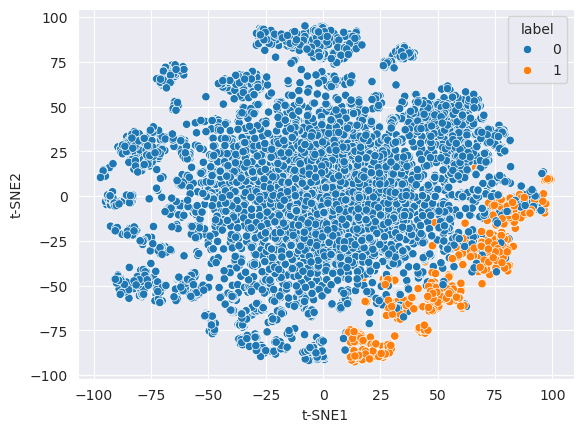

In [56]:
df_tsne = pd.DataFrame(tsne_arr, columns=["t-SNE1", "t-SNE2"])
df_tsne["label"] = c.labels_
df_tsne["Source"] = data_vect["Source"]
sns.scatterplot(df_tsne, x="t-SNE1", y="t-SNE2", hue="label", palette=sns.color_palette(n_colors=2))

In [57]:
data_mqn = df.join(
    pd.DataFrame(
        (rdMolDescriptors.MQNs_(mol) for mol in df["mol"]), 
        columns=[f"MQN{i}" for i in range(1,43)]))

norm = preprocessing.normalize(data_mqn.drop(columns=["ID", "Smiles", "mol", "Source"]))
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(norm), columns=["PC1", "PC2"])
pca_data["Source"] = data_mqn["Source"]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

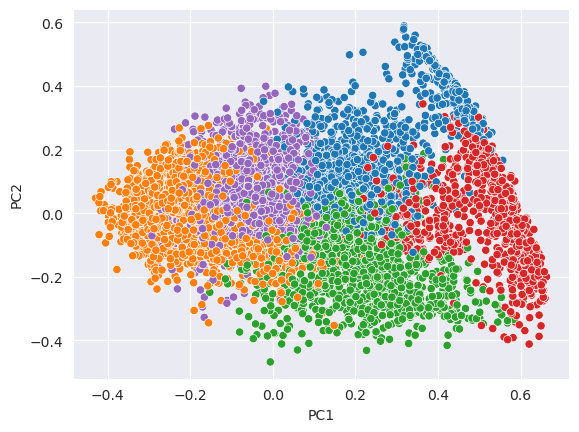

In [62]:
c2 = cluster.AgglomerativeClustering(linkage="ward", n_clusters=5)
c2.fit(norm)
pca_data["labels"] = c2.labels_
sns.scatterplot(pca_data, x="PC1", y="PC2", hue="labels", palette=sns.color_palette(n_colors=5), legend=False)

<AxesSubplot:xlabel='t-SNE1', ylabel='t-SNE2'>

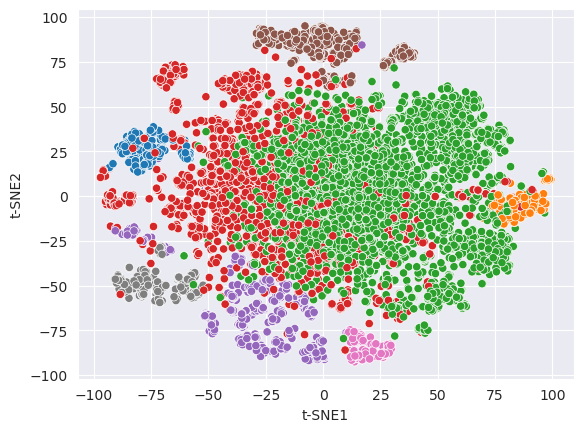

In [84]:
kmeans = cluster.KMeans()
kmeans.fit(data_vect.drop(columns=["ID", "Smiles", "mol", "Source"]))
df_tsne["labels"] = kmeans.labels_
sns.scatterplot(df_tsne, x="t-SNE1", y="t-SNE2", hue="labels", palette=sns.color_palette(n_colors=8), legend=False)

/home/vilifo/miniconda3/envs/cdd/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/vilifo/miniconda3/envs/cdd/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


<AxesSubplot:xlabel='t-SNE1', ylabel='t-SNE2'>

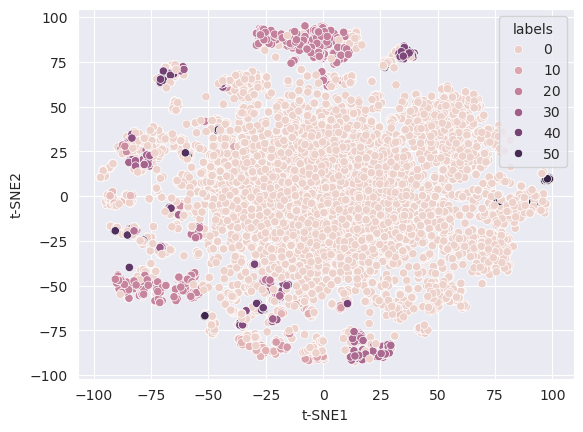

In [93]:
dbscan = cluster.DBSCAN(eps=0.3, min_samples=10, n_jobs=-1, metric="jaccard")
dbscan.fit(data_vect.drop(columns=["ID", "Smiles", "mol", "Source"]))
df_tsne["labels"] = dbscan.labels_
sns.scatterplot(df_tsne, x="t-SNE1", y="t-SNE2", hue="labels")